In [17]:
#### Import Section
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import env
import wrangle_zillow
from os.path import exists
import scipy.stats as stats

from itertools import product
from scipy.stats import levene , pearsonr, spearmanr, mannwhitneyu, f_oneway, ttest_ind
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE, f_regression, SelectKBest
import explore_zillow

from sklearn.cluster import KMeans
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

In [18]:
df, train, validate, test, train_scaled, validate_scaled, test_scaled = wrangle_zillow.wrangle_zillow()

(28971, 22) (12417, 22) (10348, 22)
-----
DataFrame info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51736 entries, 1727539 to 1187175
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   basementsqft                51736 non-null  float64 
 1   bathrooms                   51736 non-null  float64 
 2   bedrooms                    51736 non-null  float64 
 3   area                        51736 non-null  float64 
 4   county                      51736 non-null  object  
 5   garagecarcnt                51736 non-null  float64 
 6   garagetotalsqft             51736 non-null  float64 
 7   latitude                    51736 non-null  float64 
 8   longitude                   51736 non-null  float64 
 9   lotsizesquarefeet           51736 non-null  float64 
 10  poolcnt                     51736 non-null  float64 
 11  structuretaxvaluedollarcnt  51736 non-null  float64 
 12  home_va

In [19]:
#train["aircon_encoded"] =  np.where(train.aircon == "None", 0,
#                                np.where(train.aircon == "Central", 1, 2))
#
#train["heating_encoded"] =  np.where(train.heating == "Central", 0,
#                                np.where(train.heating == "None", 1,
#                                np.where(train.heating == "Floor/Wall", 2, 3)))
#
#train["county_encoded"] =  np.where(train.county == "LA County", 0,
#                                np.where(train.county == "Orange County", 1, 2))

In [20]:
target = "logerror"

continous_list = [  'basementsqft',
                    'area',
                    'garagetotalsqft',
                    'latitude',
                    'longitude',
                    'lotsizesquarefeet',
                    'structuretaxvaluedollarcnt',
                    'home_value',
                    'landtaxvaluedollarcnt',
                    "tax_per_sqft",
                    'logerror',
                    'age',
                    "openness",
                    'est_tax_rate']

discrete_list = [   'aircon',
                    'bathrooms',
                    'bedrooms',
                    'home_size',
                    'logerror_bin',
                    'heating']

In [21]:

import matplotlib.patches as patches

In [22]:
def explore_inital_guidance(train):
    """  
    takes in train and creates a previous made list of features to heatmap in the guidance of exploration
    """
    heatmap_list = ['basementsqft','area','garagetotalsqft','latitude','longitude',
                    'lotsizesquarefeet','structuretaxvaluedollarcnt','home_value',
                    'landtaxvaluedollarcnt','logerror','age','home_size','est_tax_rate',
                    "bathrooms","bedrooms","openness"]

    fig,ax = plt.subplots(figsize=(18,12))

    kwargs = {'alpha':1,
                'linewidth':5, 
                'linestyle':'--',
                'linecolor':'white'}

    sns.heatmap(train[heatmap_list].corr(),
                cmap="Spectral",
                mask=(np.triu(np.ones_like(train[heatmap_list].corr(),dtype=bool))),
                annot=True,
                vmin=-1, 
                vmax=1, 
                #annot=True,
                **kwargs
                )
    ax.add_patch(
        patches.Rectangle(
            (9, 10),
            1.0,
            35.0,
            edgecolor='red',
            fill=False,
            lw=4
        ) )
    ax.add_patch(
        patches.Rectangle(
            (9,9),
            -10.0,
            1.0,
            edgecolor='red',
            fill=False,
            lw=4
        ) )
    plt.xticks(rotation = 60)
    plt.title("Are there features that correlate higher than others?")
    plt.show()

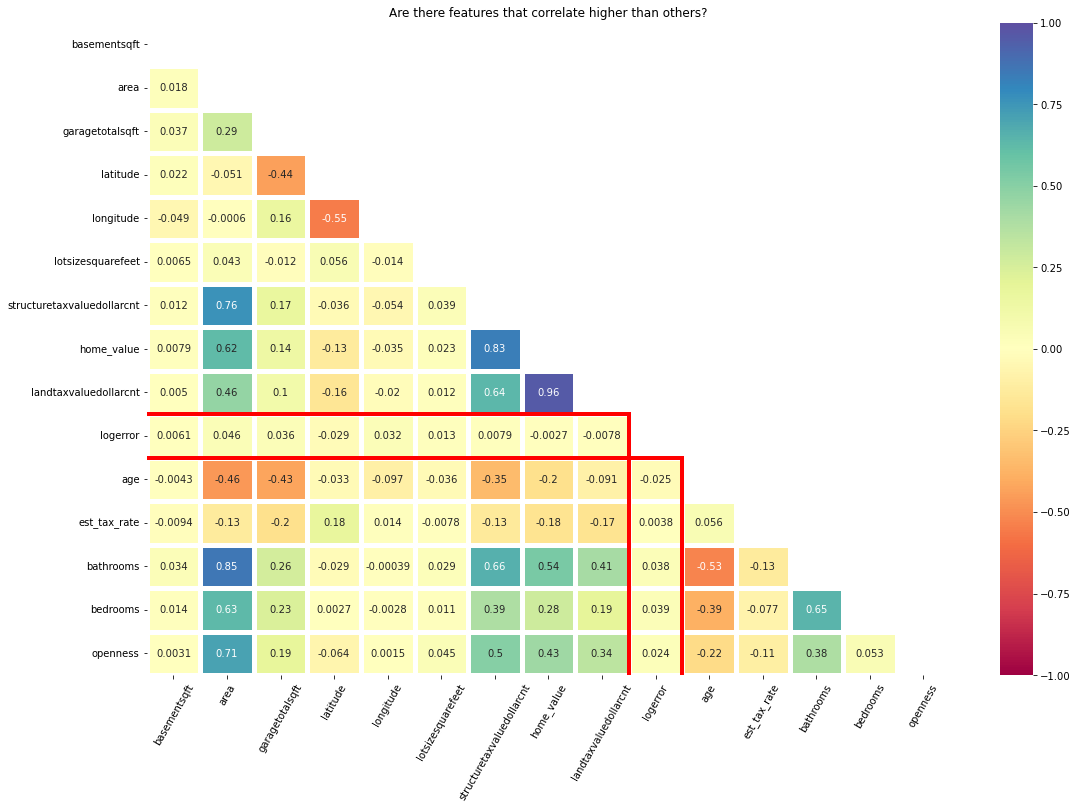

In [23]:
heatmap_list = ['basementsqft','area','garagetotalsqft','latitude','longitude',
                  'lotsizesquarefeet','structuretaxvaluedollarcnt','home_value',
                  'landtaxvaluedollarcnt','logerror','age','home_size','est_tax_rate',
                  "bathrooms","bedrooms","openness"]

fig,ax = plt.subplots(figsize=(18,12))

kwargs = {'alpha':1,
            'linewidth':5, 
            'linestyle':'--',
            'linecolor':'white'}

sns.heatmap(train[heatmap_list].corr(),
            cmap="Spectral",
            mask=(np.triu(np.ones_like(train[heatmap_list].corr(),dtype=bool))),
            annot=True,
            vmin=-1, 
            vmax=1, 
            #annot=True,
            **kwargs
            )
ax.add_patch(
     patches.Rectangle(
         (9, 10),
         1.0,
         35.0,
         edgecolor='red',
         fill=False,
         lw=4
     ) )
ax.add_patch(
     patches.Rectangle(
         (9,9),
         -10.0,
         1.0,
         edgecolor='red',
         fill=False,
         lw=4
     ) )
plt.xticks(rotation = 60)
plt.title("Are there features that correlate higher than others?")
plt.show()

observations: area, garagesqft,latt,long are best for correlation value with logerror
openness does not help that much

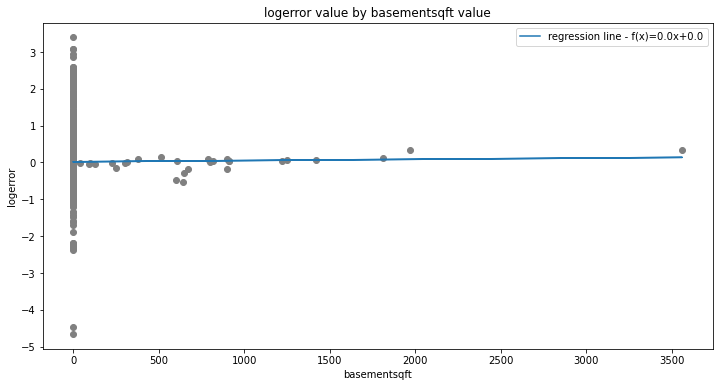

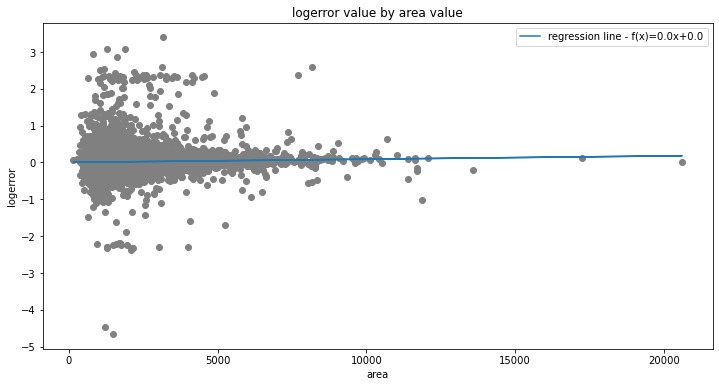

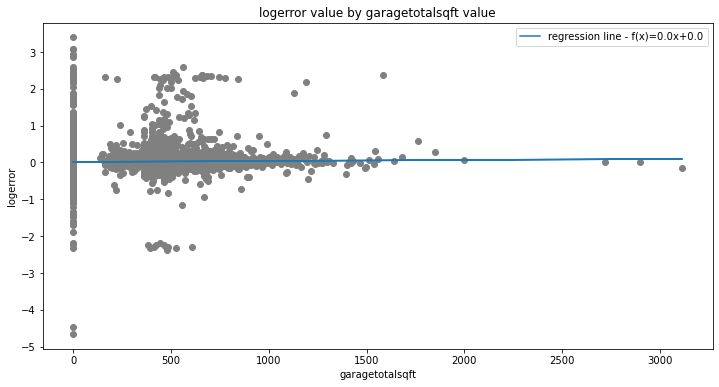

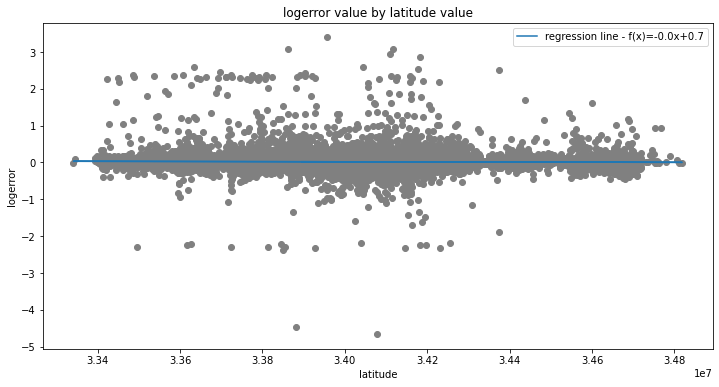

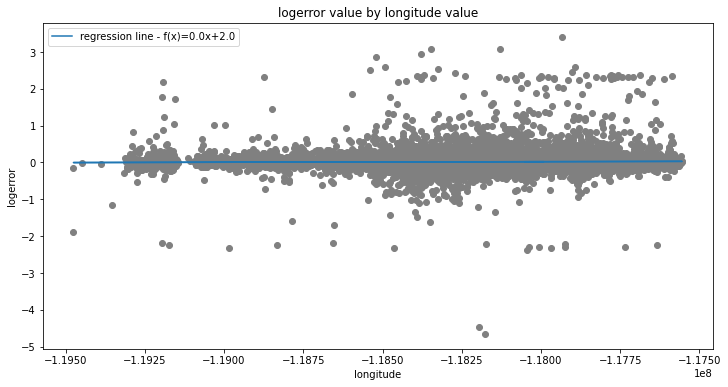

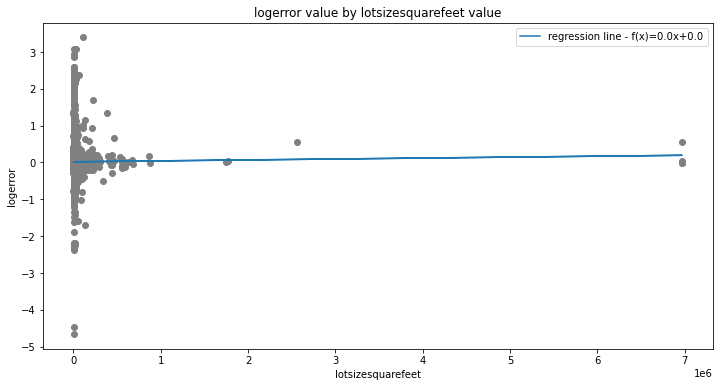

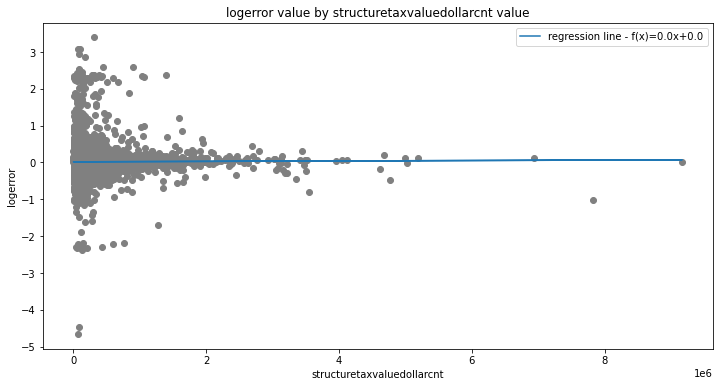

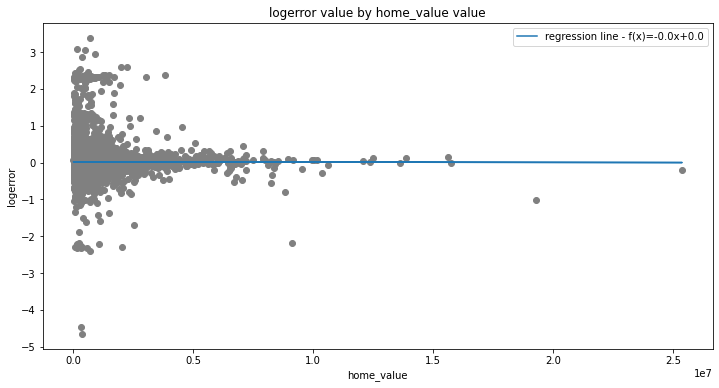

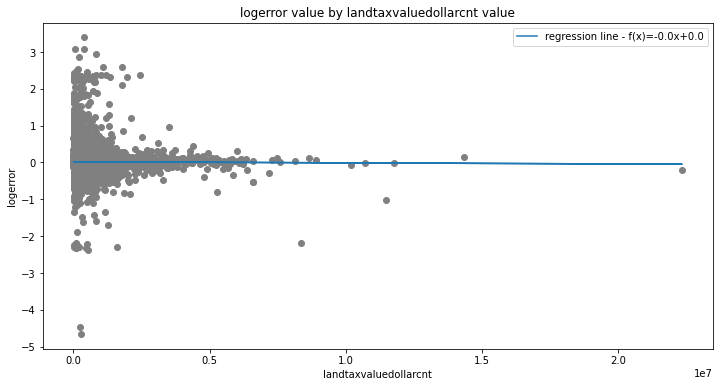

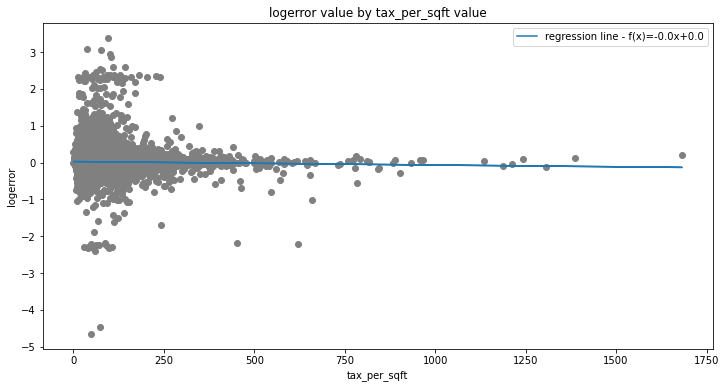

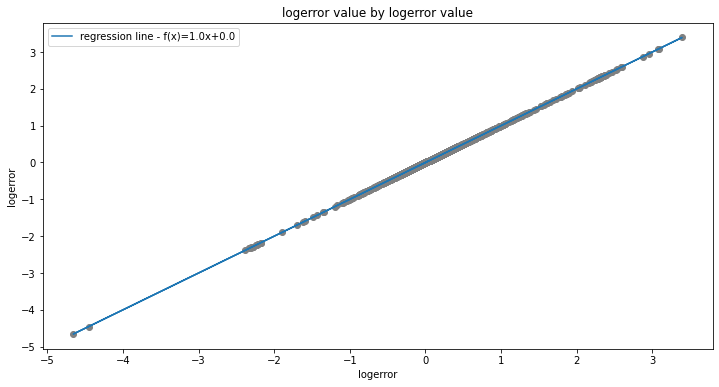

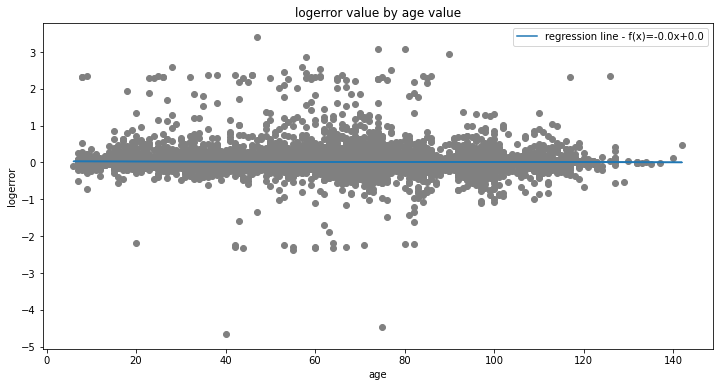

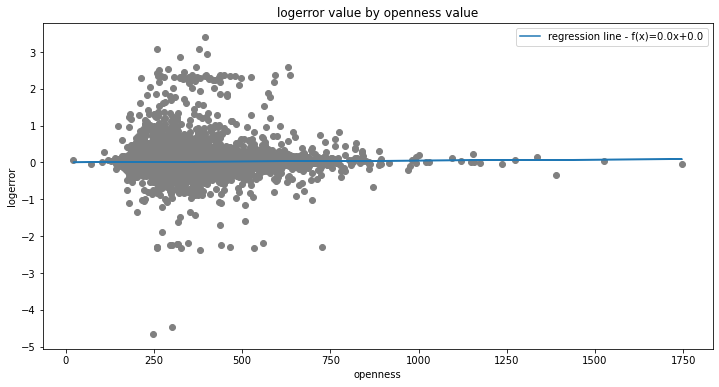

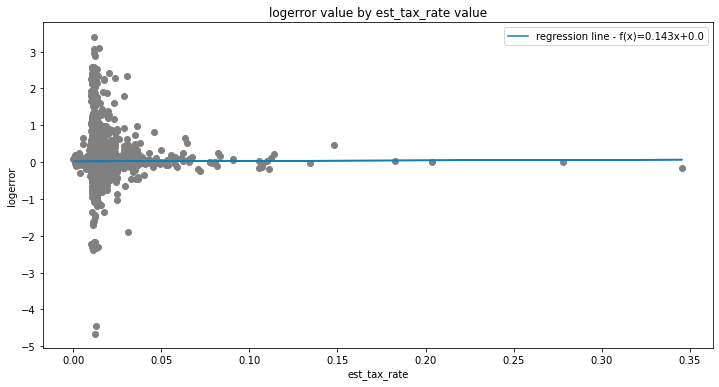

In [24]:
for col1 in continous_list:
            plt.figure(figsize=(12, 6))
            x=train[col1]
            y=train[target]
            plt.plot(x, y, "o",color="grey")
            m,b = np.polyfit(x,y,1)
            plt.plot(x,m*x+b,label=f"regression line - f(x)={round(m,3)}x+{round(b,1)}")
            plt.xlabel(col1)
            plt.ylabel(target)
            plt.legend()
            plt.title(f"{target} value by {col1} value")
            plt.show()

In [25]:
train.logerror.describe()

count    28971.000000
mean         0.019620
std          0.186604
min         -4.655420
25%         -0.024775
50%          0.006850
75%          0.040348
max          3.394544
Name: logerror, dtype: float64

In [26]:
train["logerror_bin"] = np.where(train.logerror > (train.logerror.describe()["std"]+train.logerror.describe()["mean"]),">1sig",
                                np.where(train.logerror > (train.logerror.describe()["mean"] - train.logerror.describe()["std"]),"<1sig","-1sig~1sig"))
test_results = pd.DataFrame(columns=['test', 'var1', "var2", "comparing on", "test_value", "p_val"])

cat="logerror_bin"

for num in continous_list:

    alpha = .05

    for cat_1 in train[cat].unique():
        for cat_2 in train[cat].unique():
            if not train[cat].unique().tolist().index(cat_2) >= train[cat].unique().tolist().index(cat_1):
                
                stat,pval = stats.levene(train[train[cat] == cat_1][num],train[train[cat] == cat_2][num])
                stat,pval
                if pval > 0.05:
                    equal_var_flag = True
                else:
                    equal_var_flag = False

                t, p = stats.ttest_ind( train[train[cat] == cat_1][num], train[train[cat] == cat_2][num], equal_var = equal_var_flag )

                test_results.loc[len(test_results.index)] = ["ttest 2 sided, sample to sample", 
                                                                f"{cat}({cat_1})",
                                                                f"{cat}({cat_2})",
                                                                num,
                                                                t,
                                                                p]
test_results

,test,var1,var2,comparing on,test_value,p_val
0,"ttest 2 sided, sample to sample",logerror_bin(<1sig),logerror_bin(-1sig~1sig),basementsqft,-1.634743,1.024584e-01
1,"ttest 2 sided, sample to sample",logerror_bin(>1sig),logerror_bin(-1sig~1sig),basementsqft,0.242742,8.082279e-01
2,"ttest 2 sided, sample to sample",logerror_bin(>1sig),logerror_bin(<1sig),basementsqft,1.182051,2.373960e-01
3,"ttest 2 sided, sample to sample",logerror_bin(<1sig),logerror_bin(-1sig~1sig),area,0.402593,6.873433e-01
4,"ttest 2 sided, sample to sample",logerror_bin(>1sig),logerror_bin(-1sig~1sig),area,1.748480,8.052034e-02
5,"ttest 2 sided, sample to sample",logerror_bin(>1sig),logerror_bin(<1sig),area,2.271378,2.327489e-02
6,"ttest 2 sided, sample to sample",logerror_bin(<1sig),logerror_bin(-1sig~1sig),garagetotalsqft,12.160723,9.586292e-32
7,"ttest 2 sided, sample to sample",logerror_bin(>1sig),logerror_bin(-1sig~1sig),garagetotalsqft,6.280135,4.090689e-10
8,"ttest 2 sided, sample to sample",logerror_bin(>1sig),logerror_bin(<1sig),garagetotalsqft,-3.323433,9.112750e-04
9,"ttest 2 sided, sample to sample",logerror_bin(<1sig),logerror_bin(-1sig~1sig),latitude,-3.400051,7.018348e-04


In [27]:
num="logerror"
for cat in discrete_list:

    alpha = .05

    for cat_1 in train[cat].unique():
        for cat_2 in train[cat].unique():
            if not train[cat].unique().tolist().index(cat_2) >= train[cat].unique().tolist().index(cat_1):
                H0 = f"{num} of {cat}{cat_1} has identical average values to {num} of other {cat}{cat_2}"
                Ha = f"{num} of {cat} is not equal to {num} of other {cat}"
                stat,pval = stats.levene(train[train[cat] == cat_1][num],train[train[cat] == cat_2][num])
                stat,pval
                if pval > 0.05:
                    equal_var_flag = True
                else:
                    equal_var_flag = False

                t, p = stats.ttest_ind( train[train[cat] == cat_1][num], train[train[cat] == cat_2][num], equal_var = equal_var_flag )

                test_results.loc[len(test_results.index)] = ["ttest 2 sided, sample to sample", 
                                                                f"{cat}({cat_1})",
                                                                f"{cat}({cat_2})",
                                                                num,
                                                                t,
                                                                p]
test_results


,test,var1,var2,comparing on,test_value,p_val
0,"ttest 2 sided, sample to sample",logerror_bin(<1sig),logerror_bin(-1sig~1sig),basementsqft,-1.634743,1.024584e-01
1,"ttest 2 sided, sample to sample",logerror_bin(>1sig),logerror_bin(-1sig~1sig),basementsqft,0.242742,8.082279e-01
2,"ttest 2 sided, sample to sample",logerror_bin(>1sig),logerror_bin(<1sig),basementsqft,1.182051,2.373960e-01
3,"ttest 2 sided, sample to sample",logerror_bin(<1sig),logerror_bin(-1sig~1sig),area,0.402593,6.873433e-01
4,"ttest 2 sided, sample to sample",logerror_bin(>1sig),logerror_bin(-1sig~1sig),area,1.748480,8.052034e-02
...,...,...,...,...,...,...
328,"ttest 2 sided, sample to sample",heating(Central),heating(Floor/Wall),logerror,-0.098095,9.218581e-01
329,"ttest 2 sided, sample to sample",heating(Central),heating(None),logerror,-4.959848,7.108274e-07
330,"ttest 2 sided, sample to sample",heating(Other),heating(Floor/Wall),logerror,0.145345,8.845217e-01
331,"ttest 2 sided, sample to sample",heating(Other),heating(None),logerror,-1.313146,1.900040e-01


In [28]:
test_results.p_val.value_counts(dropna=False)

NaN              50
8.260073e-132     2
2.024547e-213     2
0.000000e+00      2
4.563774e-01      1
                 ..
2.498643e-01      1
3.421925e-01      1
5.260167e-01      1
2.889034e-01      1
8.576611e-01      1
Name: p_val, Length: 281, dtype: int64

# # is the average of the sample "bedrooms (2-5)" equal to the population of bedrooms regarding log error

In [29]:
num="logerror"
alpha = .05

bedroom_list = [2.0,3.0,4.0,5.0]

for each in bedroom_list:

    population_name = "bedrooms"
    sample_name = each
    target = target
    
    H0 = f"{sample_name} as a sample has equal average values to {population_name} as a population regarding {target}"
    Ha = f"{sample_name} as a sample does not have equal average values to {population_name} as a population regarding {target}"

    print("-----------------------------")
    print(f"mean of sample = {round(train[train[population_name] == sample_name][target].mean(),3)}, \
        std of sample = {round(train[train[population_name] == sample_name][target].std(),3)}, \
            count of sample = {len(train[train[population_name] == sample_name][target])}")
    print(f"mean of pop = {round(train[target].mean(),3)}, std of pop = {round(train[target].std(),3)}")


    t, p = stats.ttest_1samp( train[train[population_name] == sample_name][target], train[target].mean())
    if p > alpha:
        print("\n We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
    else:
        print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))


-----------------------------
mean of sample = 0.014,         std of sample = 0.199,             count of sample = 4637
mean of pop = 0.02, std of pop = 0.187

 We reject the null Hypothesis ( 2̶.̶0̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶b̶e̶d̶r̶o̶o̶m̶s̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ) t=-1.99028, p=0.04662
-----------------------------
mean of sample = 0.014,         std of sample = 0.173,             count of sample = 12997
mean of pop = 0.02, std of pop = 0.187

 We reject the null Hypothesis ( 3̶.̶0̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶b̶e̶d̶r̶o̶o̶m̶s̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ) t=-3.42416, p=0.00062
-----------------------------
mean of sample = 0.025,         std of sample = 0.191,             count of sample = 8401
mean of pop = 0.02, std of pop = 0.187

 We reject the null Hypothesis ( 4̶.̶0̶ ̶a̶s̶ ̶a̶ ̶s̶a̶

2,3 and 5 bedrooms are deviant

# # is the average of the sample "bathroom (2-5)" equal to the population of bathrooms regarding log error

In [30]:
num="logerror"
alpha = .05

bathroom_list = [2.0,3.0,4.0,5.0]

for each in bathroom_list:

    population_name = "bathrooms"
    sample_name = each
    target = target
    
    H0 = f"{sample_name} as a sample has equal average values to {population_name} as a population regarding {target}"
    Ha = f"{sample_name} as a sample does not have equal average values to {population_name} as a population regarding {target}"

    print("-----------------------------")
    print(f"mean of sample = {round(train[train[population_name] == sample_name][target].mean(),3)}, \
        std of sample = {round(train[train[population_name] == sample_name][target].std(),3)}, \
            count of sample = {len(train[train[population_name] == sample_name][target])}")
    print(f"mean of pop = {round(train[target].mean(),3)}, std of pop = {round(train[target].std(),3)}")


    t, p = stats.ttest_1samp( train[train[population_name] == sample_name][target], train[target].mean())
    if p > alpha:
        print("\n We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
    else:
        print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))

-----------------------------
mean of sample = 0.014,         std of sample = 0.173,             count of sample = 12229
mean of pop = 0.02, std of pop = 0.187

 We reject the null Hypothesis ( 2̶.̶0̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶b̶a̶t̶h̶r̶o̶o̶m̶s̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ) t=-3.38851, p=0.00070
-----------------------------
mean of sample = 0.019,         std of sample = 0.15,             count of sample = 5841
mean of pop = 0.02, std of pop = 0.187

 We fail to reject the null hypothesis ( 3.0 as a sample has equal average values to bathrooms as a population regarding logerror ) t=-0.17792, p=0.85879
-----------------------------
mean of sample = 0.042,         std of sample = 0.226,             count of sample = 1193
mean of pop = 0.02, std of pop = 0.187

 We reject the null Hypothesis ( 4̶.̶0̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶b̶a̶t̶h̶r̶o

4 bathrooms are deviant

In [31]:
def explore_house_locale_cluster(train):    
    ''' 
    specific made function, takes in train and runs a tailored function that 
    does a 1 sample ttest based on predefined expectations and plots a the sub-cat in relation to non sub-cat for that feature
    '''
    # sets variables
    target = "logerror"
    alpha = .05

    population_name = 'cluster house_locale'
    sample_name = 1
    
    #sets null hypothesis
    H0 = f"{sample_name} as a sample has equal average values to {population_name} as a population regarding {target}"
    Ha = f"{sample_name} as a sample does not have equal average values to {population_name} as a population regarding {target}"

    #runs test and prints results
    t, p = stats.ttest_1samp( train[train[population_name] == sample_name][target], train[target].mean())
    if p > alpha:
        print("\n We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
    else:
        print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))

    #creates a temp df that assists in plotting the feature
    temp1 = train.copy()
    temp1["House Locale Compared"] = np.where(temp1[population_name] == sample_name,"Cluster 1", "Other Clusters")

    #does the plotting
    plt.figure(figsize=(12,6))
    sns.barplot(
        data=temp1, x="House Locale Compared", y="logerror",
        linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0),
    )
    plt.axhline(y=temp1.logerror.mean(),label=f"LogError Mean {round(temp1.logerror.mean(),3)}",color="black")
    plt.legend()
    plt.title("House Locale Compared Compared in relation to LogError")
    plt.show()


 We reject the null Hypothesis ( 1̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶c̶l̶u̶s̶t̶e̶r̶ ̶h̶o̶u̶s̶e̶_̶l̶o̶c̶a̶l̶e̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ) t=-4.99665, p=0.00000


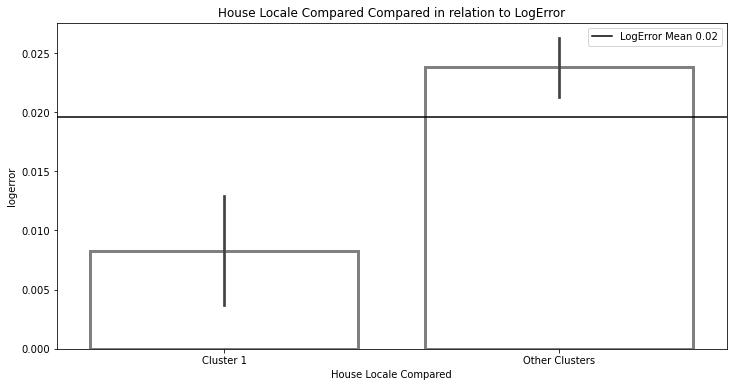

In [32]:
explore_house_locale_cluster(train)

In [33]:
fig = px.scatter_geo( data_frame = train,
                lat = train.latitude/1_000_000,
                lon = train.longitude/1_000_000,
                #symbol = train.logerror,
                color = train['cluster house_locale'],
                center= {"lat":(train.latitude/1_000_000).mean(),"lon":(train.longitude/1_000_000).mean()}
                )
fig.update_geos(fitbounds="locations")
fig.update_layout(
        title = 'Single Family Houses Sold in 2017<br>California',
        geo_scope='usa',
        height=500, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# is the average of the sample "large" equal to the population of home_size regarding log error

In [34]:
num="logerror"
alpha = .05

population_name = "home_size"
sample_name = "large"
target=target
   
H0 = f"{sample_name} as a sample has equal average values to {population_name} as a population regarding {target}"
Ha = f"{sample_name} as a sample does not have equal average values to {population_name} as a population regarding {target}"

print("-----------------------------")
print(f"mean of sample = {round(train[train[population_name] == sample_name][target].mean(),3)}, \
    std of sample = {round(train[train[population_name] == sample_name][target].std(),3)}, \
        count of sample = {len(train[train[population_name] == sample_name][target])}")
print(f"mean of pop = {round(train[target].mean(),3)}, std of pop = {round(train[target].std(),3)}")


t, p = stats.ttest_1samp( train[train[population_name] == sample_name][target], train[target].mean())
if p > alpha:
    print("\n We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
else:
    print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))


-----------------------------
mean of sample = 0.032,     std of sample = 0.204,         count of sample = 7090
mean of pop = 0.02, std of pop = 0.187

 We reject the null Hypothesis ( l̶a̶r̶g̶e̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶h̶o̶m̶e̶_̶s̶i̶z̶e̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ) t=5.23334, p=0.00000


# is the average of the sample "no heating" equal to the population of heating regarding log error

In [35]:
def explore_heating(train):
    ''' 
    specific made function, takes in train and runs a tailored function that 
    does a 1 sample ttest based on predefined expectations and plots a the sub-cat in relation to non sub-cat for that feature
    '''
    # sets variables
    target = "logerror"
    alpha = .05

    population_name = "heating"
    sample_name = "None"
    
    #sets null hypothesis
    H0 = f"{sample_name} as a sample has equal average values to {population_name} as a population regarding {target}"
    Ha = f"{sample_name} as a sample does not have equal average values to {population_name} as a population regarding {target}"

    #runs test and prints results
    t, p = stats.ttest_1samp( train[train[population_name] == sample_name][target], train[target].mean())
    if p > alpha:
        print("\n We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
    else:
        print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))

    #creates a temp df that assists in plotting the feature
    temp1 = train.copy()
    temp1["Heating Compared"] = np.where(temp1[population_name] == sample_name,"Heating - No", "Heating - Yes")

    #does the plotting
    plt.figure(figsize=(12,6))
    sns.barplot(
        data=temp1, x="Heating Compared", y="logerror",
        linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0),
    )
    plt.axhline(y=temp1.logerror.mean(),label=f"LogError Mean {round(temp1.logerror.mean(),3)}",color="black")
    plt.legend()
    plt.title("Heating Compared in relation to LogError")
    plt.show()

# scaling for groups

## first group

In [36]:
dict_to_cluster = { "house_tax":["tax_per_sqft","est_tax_rate","openness"],
                    "house_details":["lotsizesquarefeet",'garagetotalsqft',"poolcnt"],
                    "house_sizing":['area', 'bathrooms', 'bedrooms'],
                    "house_locale":["latitude","longitude","age"],
                    "cluster_order":[5,4,5,5]}


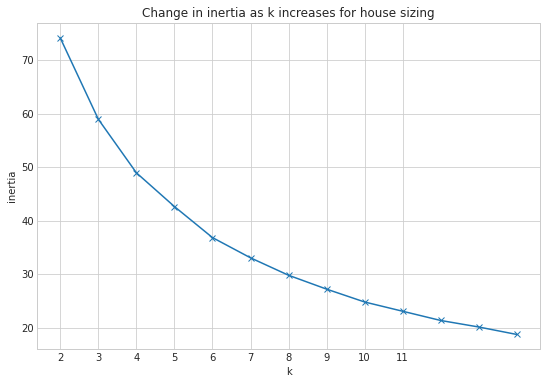

In [37]:
X = train[dict_to_cluster[list(dict_to_cluster)[0]]]
# make, fit, apply:
scaler = MinMaxScaler()
# train is all numerical so I can call the whole thing
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    index = X.index,
    columns = X.columns)

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 15)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases for house sizing')

In [38]:
kmeans_scaled = KMeans(n_clusters=5)
kmeans_scaled.fit(X_scaled)
X_scaled["cluster"] = kmeans_scaled.predict(X_scaled)
train[f"cluster {list(dict_to_cluster)[0]}"] = X_scaled["cluster"]
X_scaled.groupby(["cluster"]).agg(["mean","min","max"])

tax_per_sqft                     est_tax_rate                      \
                mean       min       max         mean       min       max   
cluster                                                                     
0           0.044645  0.000240  0.105022     0.037188  0.002465  0.235428   
1           0.038351  0.000070  0.108594     0.040752  0.000852  1.000000   
2           0.077482  0.000000  0.264262     0.035034  0.000000  0.305246   
3           0.276264  0.171758  1.000000     0.033241  0.003590  0.038936   
4           0.083673  0.049083  0.190158     0.035039  0.002029  0.095196   

         openness                      
             mean       min       max  
cluster                                
0        0.210570  0.175724  0.272584  
1        0.142654  0.029146  0.190743  
2        0.296637  0.235875  1.000000  
3        0.215125  0.000000  0.445978  
4        0.171875  0.069487  0.237228

In [39]:
cluster_test_results = pd.DataFrame(columns=['test', 'population', "variable", "comparing on", "test_value", "p_val"])

num="logerror"
cat = f"cluster {list(dict_to_cluster)[0]}"
alpha = .05

for each in train[cat].unique():

    population_name = cat
    sample_name = each
    target = target
    
    t, p = stats.ttest_1samp( train[train[population_name] == sample_name][target], train[target].mean())

    cluster_test_results.loc[len(cluster_test_results.index)] = ["ttest 2 sided, sample to sample", 
                                                            f"{cat}",
                                                            f"{cat}({each})",
                                                            num,
                                                            t,
                                                            p]
cluster_test_results.sort_values(by=["p_val"])

,test,population,variable,comparing on,test_value,p_val
2,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(4),logerror,-4.703223,0.000003
1,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(2),logerror,3.128935,0.001774
4,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(3),logerror,-2.685666,0.007755
0,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(0),logerror,1.704864,0.088257
3,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(1),logerror,-0.103666,0.917436


## Second group

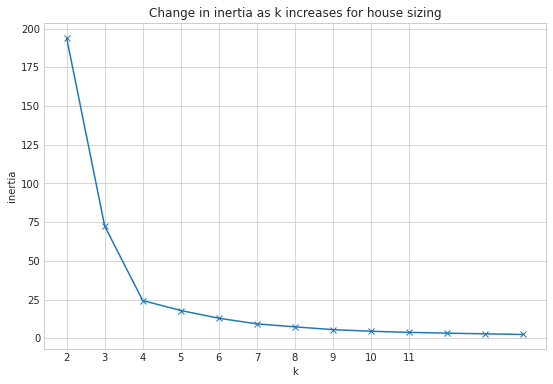

In [40]:
X = train[dict_to_cluster[list(dict_to_cluster)[1]]]
# make, fit, apply:
scaler = MinMaxScaler()
# train is all numerical so I can call the whole thing
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    index = X.index,
    columns = X.columns)

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 15)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases for house sizing')



In [41]:
kmeans_scaled = KMeans(n_clusters=4)
kmeans_scaled.fit(X_scaled)
X_scaled["cluster"] = kmeans_scaled.predict(X_scaled)

train[f"cluster {list(dict_to_cluster)[1]}"] = X_scaled["cluster"]
X_scaled.groupby(["cluster"]).agg(["mean","min","max"])

lotsizesquarefeet                     garagetotalsqft            \
                     mean       min       max            mean       min   
cluster                                                                   
0                0.000993  0.000061  0.037967        0.156650  0.078652   
1                0.002168  0.000083  0.367538        0.000232  0.000000   
2                0.001683  0.000044  1.000000        0.000626  0.000000   
3                0.001783  0.000000  0.063081        0.182518  0.096308   

                  poolcnt            
              max    mean  min  max  
cluster                              
0        0.931300     0.0  0.0  0.0  
1        0.089888     1.0  1.0  1.0  
2        0.078331     0.0  0.0  0.0  
3        1.000000     1.0  1.0  1.0

In [42]:

num="logerror"
cat = f"cluster {list(dict_to_cluster)[1]}"
alpha = .05

for each in train[cat].unique():

    population_name = cat
    sample_name = each
    target = target
    
    t, p = stats.ttest_1samp( train[train[population_name] == sample_name][target], train[target].mean())

    cluster_test_results.loc[len(cluster_test_results.index)] = ["ttest 2 sided, sample to sample", 
                                                            f"{cat}",
                                                            f"{cat}({each})",
                                                            num,
                                                            t,
                                                            p]
cluster_test_results.sort_values(by=["p_val"])

,test,population,variable,comparing on,test_value,p_val
2,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(4),logerror,-4.703223,0.000003
8,"ttest 2 sided, sample to sample",cluster house_details,cluster house_details(0),logerror,3.964288,0.000074
1,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(2),logerror,3.128935,0.001774
7,"ttest 2 sided, sample to sample",cluster house_details,cluster house_details(1),logerror,-2.725889,0.006442
4,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(3),logerror,-2.685666,0.007755
5,"ttest 2 sided, sample to sample",cluster house_details,cluster house_details(2),logerror,-1.729775,0.083690
0,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(0),logerror,1.704864,0.088257
6,"ttest 2 sided, sample to sample",cluster house_details,cluster house_details(3),logerror,0.639394,0.522630
3,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(1),logerror,-0.103666,0.917436


## Third group

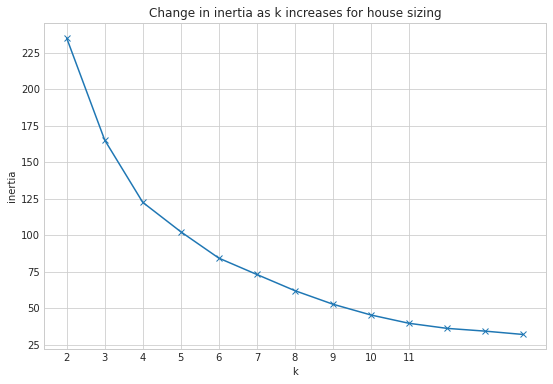

In [43]:
X = train[dict_to_cluster[list(dict_to_cluster)[2]]]
# make, fit, apply:
scaler = MinMaxScaler()
# train is all numerical so I can call the whole thing
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    index = X.index,
    columns = X.columns)

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 15)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases for house sizing')



In [44]:
kmeans_scaled = KMeans(n_clusters=5)
kmeans_scaled.fit(X_scaled)
X_scaled["cluster"] = kmeans_scaled.predict(X_scaled)

train[f"cluster {list(dict_to_cluster)[2]}"] = X_scaled["cluster"]

X_scaled.groupby(["cluster"]).agg(["mean","min","max"])

area                     bathrooms                      bedrooms  \
             mean       min       max      mean       min       max      mean   
cluster                                                                         
0        0.102120  0.022483  0.275171  0.225428  0.153846  0.576923  0.267274   
1        0.099386  0.000000  0.241593  0.198317  0.076923  0.307692  0.377799   
2        0.047815  0.006647  0.163343  0.102505  0.000000  0.230769  0.174834   
3        0.062649  0.023363  0.173754  0.136133  0.000000  0.192308  0.274057   
4        0.197251  0.076882  1.000000  0.357798  0.230769  1.000000  0.434507   

                             
              min       max  
cluster                      
0        0.000000  0.272727  
1        0.363636  0.636364  
2        0.000000  0.181818  
3        0.272727  0.363636  
4        0.272727  1.000000

In [45]:

num="logerror"
cat = f"cluster {list(dict_to_cluster)[2]}"
alpha = .05

for each in train[cat].unique():

    population_name = cat
    sample_name = each
    target = target
    
    t, p = stats.ttest_1samp( train[train[population_name] == sample_name][target], train[target].mean())

    cluster_test_results.loc[len(cluster_test_results.index)] = ["ttest 2 sided, sample to sample", 
                                                            f"{cat}",
                                                            f"{cat}({each})",
                                                            num,
                                                            t,
                                                            p]
cluster_test_results.sort_values(by=["p_val"])

,test,population,variable,comparing on,test_value,p_val
13,"ttest 2 sided, sample to sample",cluster house_sizing,cluster house_sizing(4),logerror,5.922662,3.661050e-09
2,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(4),logerror,-4.703223,2.625606e-06
8,"ttest 2 sided, sample to sample",cluster house_details,cluster house_details(0),logerror,3.964288,7.431146e-05
1,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(2),logerror,3.128935,1.774467e-03
10,"ttest 2 sided, sample to sample",cluster house_sizing,cluster house_sizing(3),logerror,-2.875420,4.043436e-03
7,"ttest 2 sided, sample to sample",cluster house_details,cluster house_details(1),logerror,-2.725889,6.441840e-03
4,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(3),logerror,-2.685666,7.754711e-03
12,"ttest 2 sided, sample to sample",cluster house_sizing,cluster house_sizing(0),logerror,-2.138405,3.255638e-02
5,"ttest 2 sided, sample to sample",cluster house_details,cluster house_details(2),logerror,-1.729775,8.369048e-02
0,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(0),logerror,1.704864,8.825740e-02


## Fourth (last) group

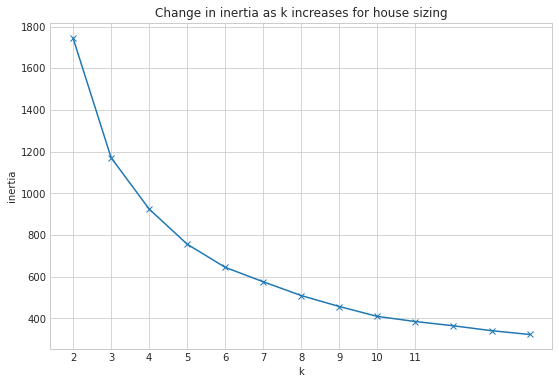

In [46]:
X = train[dict_to_cluster[list(dict_to_cluster)[3]]]
# make, fit, apply:
scaler = MinMaxScaler()
# train is all numerical so I can call the whole thing
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    index = X.index,
    columns = X.columns)

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 15)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases for house sizing')



In [47]:
kmeans_scaled = KMeans(n_clusters=5)
kmeans_scaled.fit(X_scaled)
X_scaled["cluster"] = kmeans_scaled.predict(X_scaled)

train[f"cluster {list(dict_to_cluster)[3]}"] = X_scaled["cluster"]
X_scaled.groupby(["cluster"]).agg(["mean","min","max"])

latitude                     longitude                           age  \
             mean       min       max      mean       min       max      mean   
cluster                                                                         
0        0.374018  0.000000  0.585806  0.757229  0.546302  0.985173  0.420191   
1        0.605326  0.370573  0.789044  0.361175  0.000000  0.621899  0.298507   
2        0.227573  0.035440  0.548223  0.886615  0.555198  1.000000  0.209604   
3        0.828840  0.491635  1.000000  0.672053  0.426474  0.948320  0.207158   
4        0.502002  0.217115  0.915771  0.604216  0.092762  0.914369  0.566615   

                             
              min       max  
cluster                      
0        0.117647  0.801471  
1        0.000000  0.720588  
2        0.007353  0.507353  
3        0.007353  0.580882  
4        0.330882  1.000000

In [48]:
train

,basementsqft,bathrooms,bedrooms,area,county,garagecarcnt,garagetotalsqft,latitude,longitude,lotsizesquarefeet,...,age,openness,tax_per_sqft,home_size,est_tax_rate,cluster house_tax,cluster house_details,cluster house_sizing,cluster house_locale,logerror_bin
id,,,,,,,,,,,,,,,,,,,,,
2276667,0.0,1.0,2.0,1092.0,LA County,0.0,0.0,34064326.0,-118049996.0,9771.0,...,77.0,364.000000,76.397436,small,0.015484,0,2,2,4,-1sig~1sig
2965061,0.0,2.0,3.0,1712.0,Orange County,2.0,441.0,33545028.0,-117675259.0,8494.0,...,37.0,342.400000,89.705023,medium,0.010018,0,3,3,2,<1sig
2047898,0.0,1.0,2.0,1620.0,LA County,0.0,0.0,34018464.0,-118794354.0,44577.0,...,73.0,540.000000,33.666049,medium,0.015525,2,2,2,1,<1sig
933582,0.0,1.0,3.0,1270.0,LA County,0.0,0.0,33993715.0,-118056183.0,5562.0,...,72.0,317.500000,108.024409,medium,0.013080,4,1,3,0,<1sig
2978060,0.0,2.5,4.0,2092.0,Orange County,2.0,441.0,33793010.0,-118073478.0,7700.0,...,63.0,321.846154,39.200287,medium,0.015751,1,0,1,0,<1sig
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722189,0.0,1.0,2.0,1137.0,LA County,0.0,0.0,33903989.0,-118247411.0,5306.0,...,69.0,379.000000,18.375550,small,0.025857,0,2,2,0,<1sig
2904505,0.0,2.5,4.0,1877.0,Orange County,2.0,519.0,33816021.0,-117776867.0,1640.0,...,47.0,288.769231,83.745338,medium,0.010840,1,3,1,2,<1sig
2074270,0.0,3.5,4.0,2735.0,Ventura County,2.0,660.0,34148495.0,-118841347.0,8325.0,...,26.0,364.666667,211.088848,large,0.011266,4,3,1,1,<1sig


In [49]:
cluster_test_results = pd.DataFrame(columns=['test', 'population', "variable", "comparing on", "test_value", "p_val"])
for i in train.columns[train.columns.to_series().str.contains('cluster')].tolist():
    population_name = f"{i}"
    alpha = .05
    for sample_name in train[population_name].unique():

        t, p = stats.ttest_1samp( train[train[population_name] == sample_name][target], train[target].mean())
        cluster_test_results.loc[len(cluster_test_results.index)] = ["ttest 2 sided, sample to population", 
                                                            f"{population_name}",
                                                            f"{population_name}({sample_name})",
                                                            target,
                                                            t,
                                                            p]                                        
cluster_test_results.sort_values(by=["p_val"])


,test,population,variable,comparing on,test_value,p_val
13,"ttest 2 sided, sample to population",cluster house_sizing,cluster house_sizing(4),logerror,5.922662,3.661050e-09
14,"ttest 2 sided, sample to population",cluster house_locale,cluster house_locale(4),logerror,-5.020869,5.257251e-07
2,"ttest 2 sided, sample to population",cluster house_tax,cluster house_tax(4),logerror,-4.703223,2.625606e-06
15,"ttest 2 sided, sample to population",cluster house_locale,cluster house_locale(2),logerror,4.696397,2.725175e-06
8,"ttest 2 sided, sample to population",cluster house_details,cluster house_details(0),logerror,3.964288,7.431146e-05
1,"ttest 2 sided, sample to population",cluster house_tax,cluster house_tax(2),logerror,3.128935,1.774467e-03
10,"ttest 2 sided, sample to population",cluster house_sizing,cluster house_sizing(3),logerror,-2.875420,4.043436e-03
7,"ttest 2 sided, sample to population",cluster house_details,cluster house_details(1),logerror,-2.725889,6.441840e-03
4,"ttest 2 sided, sample to population",cluster house_tax,cluster house_tax(3),logerror,-2.685666,7.754711e-03
17,"ttest 2 sided, sample to population",cluster house_locale,cluster house_locale(0),logerror,2.155446,3.115213e-02


In [50]:
def score_clusters(train,target):
    '''
    takes in your three sets and runs one sided ttest on the cluster groups to see if they were 
    averaging significantly different averages
    '''

    #creates a data frame, to append the iteration of result from 1 sample to population result of clustering to

    cluster_test_results = pd.DataFrame(columns=['test', 'population', "variable", "comparing on", "test_value", "p_val"])

    for i in range(len(list(dict_to_cluster))-1):

        population_name = f"cluster {list(dict_to_cluster)[i]}"
        alpha = .05
        for sample_name in train[population_name].unique():
    
            t, p = stats.ttest_1samp( train[train[population_name] == sample_name][target], train[target].mean())

            cluster_test_results.loc[len(cluster_test_results.index)] = ["ttest 2 sided, sample to population", 
                                                                f"{population_name}",
                                                                f"{population_name}({sample_name})",
                                                                target,
                                                                t,
                                                                p]
                                                        
                                                        
    cluster_test_results.sort_values(by=["p_val"])
    return(cluster_test_results)

# plot for results from cluster

In [58]:
cluster_features = train.columns[train.columns.to_series().str.contains('cluster')].tolist()
cluster_features

['cluster house_tax',
 'cluster house_details',
 'cluster house_sizing',
 'cluster house_locale']

In [59]:
train["cluster house_locale"].unique().tolist()

[3, 1, 0, 2, 4]

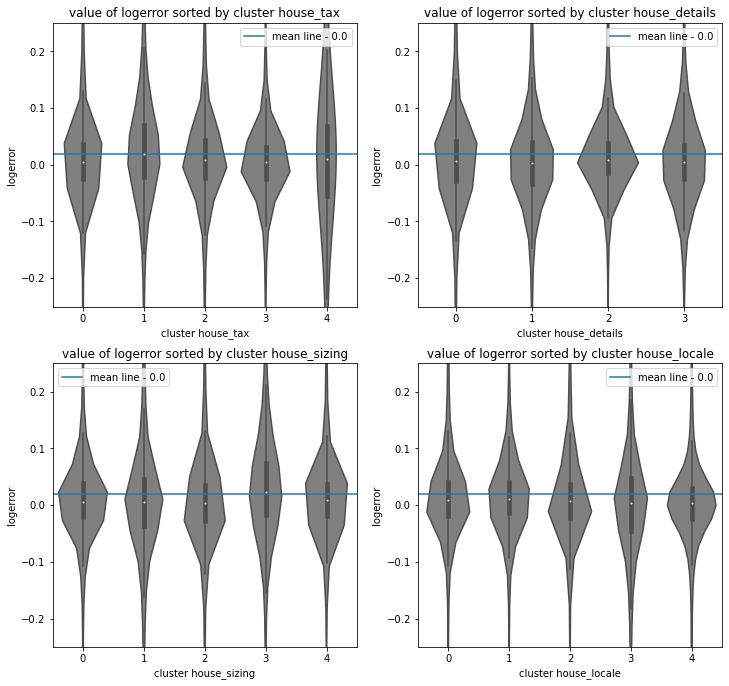

In [104]:
cluster_features = train.columns[train.columns.to_series().str.contains('cluster')].tolist()
target = "logerror"

l = 0

plt.figure(figsize=(12,24))

for cluster in cluster_features:
    l += 1
    plt.subplot(len(cluster_features),2,l)
    plot_order = train[cluster].sort_values(ascending=True).unique()
    sns.violinplot(    x=train[cluster], 
                    y=train[target], 
                    data=train, 
                    order = plot_order,
                    color ="grey",
                    inner="box"
                    #notch=True,
                    )
    plt.axhline(train[target].mean(),label=f"mean line - {round(train[target].mean(),0)}")
    plt.ylim([-.25,.25])
    plt.legend()
    plt.title(f"value of {target} sorted by {cluster}")
plt.show()

In [51]:
cluster_test_results = score_clusters(train,target)
cluster_test_results[cluster_test_results["p_val"]<.05].sort_values(by=["p_val"])

,test,population,variable,comparing on,test_value,p_val
13,"ttest 2 sided, sample to population",cluster house_sizing,cluster house_sizing(4),logerror,5.922662,3.661050e-09
14,"ttest 2 sided, sample to population",cluster house_locale,cluster house_locale(4),logerror,-5.020869,5.257251e-07
2,"ttest 2 sided, sample to population",cluster house_tax,cluster house_tax(4),logerror,-4.703223,2.625606e-06
15,"ttest 2 sided, sample to population",cluster house_locale,cluster house_locale(2),logerror,4.696397,2.725175e-06
8,"ttest 2 sided, sample to population",cluster house_details,cluster house_details(0),logerror,3.964288,7.431146e-05
1,"ttest 2 sided, sample to population",cluster house_tax,cluster house_tax(2),logerror,3.128935,1.774467e-03
10,"ttest 2 sided, sample to population",cluster house_sizing,cluster house_sizing(3),logerror,-2.875420,4.043436e-03
7,"ttest 2 sided, sample to population",cluster house_details,cluster house_details(1),logerror,-2.725889,6.441840e-03
4,"ttest 2 sided, sample to population",cluster house_tax,cluster house_tax(3),logerror,-2.685666,7.754711e-03
17,"ttest 2 sided, sample to population",cluster house_locale,cluster house_locale(0),logerror,2.155446,3.115213e-02



 We reject the null Hypothesis ( 4̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶c̶l̶u̶s̶t̶e̶r̶ ̶h̶o̶u̶s̶e̶_̶s̶i̶z̶i̶n̶g̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ) t=5.92266, p=0.00000


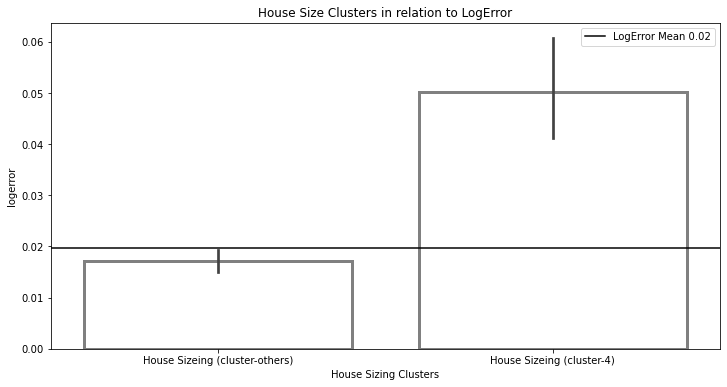

In [52]:
explore_zillow.explore_house_size_clusters(train)

In [53]:
def explore_house_size_clusters(train):
    ''' 
    specific made function, takes in train and runs a tailored function that 
    does a 1 sample ttest based on predefined expectations and plots a the sub-cat in relation to non sub-cat for that feature
    '''

    # sets variables
    target = "logerror"
    alpha = .05
    population_name = "cluster house_sizing"
    sample_name = 4

    #sets null hypothesis
    H0 = f"{sample_name} as a sample has equal average values to {population_name} as a population regarding {target}"
    Ha = f"{sample_name} as a sample does not have equal average values to {population_name} as a population regarding {target}"
    #runs test and prints results
    t, p = stats.ttest_1samp( train[train[population_name] == sample_name][target], train[target].mean())
    if p > alpha:
        print("\n We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
    else:
        print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))
    #creates a temp df that assists in plotting the feature
    temp1 = train.copy()
    temp1["House Sizing Clusters"] = np.where(temp1[population_name] == sample_name,"House Sizeing (cluster-4)", "House Sizeing (cluster-others)")
    #does the plotting
    plt.figure(figsize=(12,6))
    sns.barplot(
        data=temp1, x="House Sizing Clusters", y="logerror",
        linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0),
    )
    plt.axhline(y=temp1.logerror.mean(),label=f"LogError Mean {round(temp1.logerror.mean(),3)}",color="black")
    plt.legend()
    plt.title("House Size Clusters in relation to LogError")
    plt.show()

In [55]:
def get_kmeans_cluster_features(train,test,validate,dict_to_cluster):
    ''' 
    takes in your three datasets to apply the new featuers to as well as
    a dictionary (iterable lists with the last being the order of clustering (function to auto later))
    '''

    for i in range(len(list(dict_to_cluster))-1):
        #set features
        X1 = train[dict_to_cluster[list(dict_to_cluster)[i]]]
        X2 = validate[dict_to_cluster[list(dict_to_cluster)[i]]]
        X3 = test[dict_to_cluster[list(dict_to_cluster)[i]]]

        # make, fit, apply:
        scaler = MinMaxScaler()
        # train is all numerical so I can call the whole thing
        X1_scaled = pd.DataFrame(scaler.fit_transform(X1),index = X1.index,columns = X1.columns)
        X2_scaled = pd.DataFrame(scaler.transform(X2),index = X2.index,columns = X2.columns)
        X3_scaled = pd.DataFrame(scaler.transform(X3),index = X3.index,columns = X3.columns)

        kmeans_scaled = KMeans(n_clusters=dict_to_cluster[list(dict_to_cluster)[len(list(dict_to_cluster))-1]][i])
        kmeans_scaled.fit(X1_scaled)

        X1_scaled["cluster"] = kmeans_scaled.predict(X1_scaled)
        X2_scaled["cluster"] = kmeans_scaled.predict(X2_scaled)
        X3_scaled["cluster"] = kmeans_scaled.predict(X3_scaled)

        train[f"cluster {list(dict_to_cluster)[i]}"] = X1_scaled["cluster"]
        validate[f"cluster {list(dict_to_cluster)[i]}"] = X1_scaled["cluster"]
        test[f"cluster {list(dict_to_cluster)[i]}"] = X1_scaled["cluster"]

    return train,test,validate

In [56]:
train,test,validate = get_kmeans_cluster_features(train,test,validate,dict_to_cluster)

-
-
-
-
-
-
--
-
-
-
-
-
-
-
-

-
--
-
-
-
-
-

-
-
-
-
-
-
-
-